### Understanding and building the Cross-Stage Partial Network Architecture used in YOLO models

CSPNet uses a split and merge strategy, wherein the initial number of channels from the first few Feature Extractor Layers are split in equal halves. One such half passes through a series of Dense Blocks and the other half bypasses and concatenates with the former, thereby preventing redundant gradient flow and making it computationally efficient (only half number of channels need to pass through the Dense Convolutional blocks)

CSPNet advantages 
1. Much more memory efficient than ResNet and DenseNet and therefore takes lesser time to train
2. Helps mitigating the vanishing gradient problem during back propagation by allowign short-cut networks
3. Allows efficient utilization of both high-level and low-level feature maps

In [1]:
import cv2 as cv 
import matplotlib.pyplot as plt
import torch

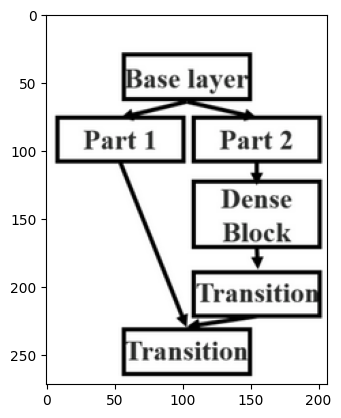

In [2]:
plt.imshow(cv.cvtColor(cv.imread('./../csp_arch.png'),cv.COLOR_BGR2RGB))

In [7]:
import torch
import torch.nn as nn

class CSPBlock(nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels=None,num_dense_blocks=1):
        super(CSPBlock,self).__init__()
        if hidden_channels is None:
            hidden_channels = out_channels        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_channels = hidden_channels
        self.num_dense_blocks = num_dense_blocks
        
        self.conv1 = nn.Conv2d(self.in_channels,self.out_channels,kernel_size = 1,bias = False,stride = 1)
        self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.relu = nn.LeakyReLU(0.1)
        
        self.conv2 = nn.Conv2d(self.out_channels//2,self.hidden_channels,kernel_size = 1,bias = False,stride = 1)
        self.bn2 = nn.BatchNorm2d(self.out_channels//2)
        self.blocks = nn.Sequential(*[nn.Sequential(
        nn.Conv2d(self.hidden_channels,self.hidden_channels,kernel_size = 3,bias = False,padding = 1),
        nn.BatchNorm2d(self.hidden_channels),
        self.relu) for _ in range(self.num_dense_blocks)])
        
        self.conv3 = nn.Conv2d(self.hidden_channels,self.out_channels//2,kernel_size=1,bias=False)
        self.bn3 = nn.BatchNorm2d(self.out_channels//2)
        
        self.transition = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )
        
    def forward(self,x):
        x1,x2 = torch.chunk(self.conv1(x),2,dim = 1)
        x1 = self.relu(self.bn1(x1))
        
        x2 = self.relu(self.bn2(self.conv2(x2)))
        x2 = self.blocks(x2)
        x2 = self.relu(self.bn3(self.conv3(x2)))
        
        x = torch.cat([x1,x2],dim = 1)
        x = self.transition(x)
        return x 

In [9]:
# Example of creating a CSPBlock
csp_block = CSPBlock(in_channels=256, out_channels=512, num_dense_blocks=3)
print(csp_block)

CSPBlock(
  (conv1): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1

### Understanding and building the Spatial Pyramid Pooling Network Architecture used in YOLO models¶

SPP enhances the models ability to handle inputs of varying sizes by using MaxPooling Layers of different sizes and concatenating them. This helps in capturing multi-scaled information

SPP advantages


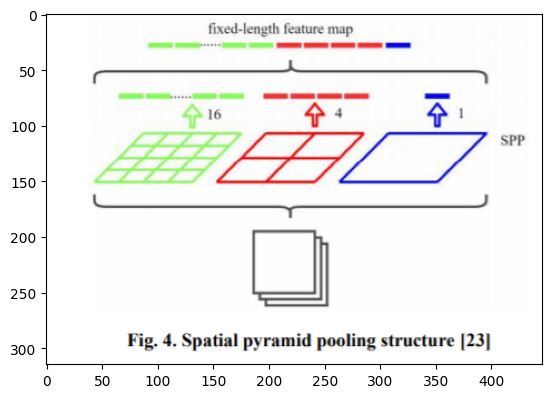

In [11]:
plt.imshow(cv.cvtColor(cv.imread('./../spp.png'),cv.COLOR_BGR2RGB))

In [12]:
class SPP(nn.Module):
    def __init__(self,inp,op,pool_list = [5,7,9]):
        super(SPP,self).__init__()
        self.maxpools = nn.ModuleList([nn.MaxPool2d(pool_size,1,pool_size//2) for pool_size in pool_list ])
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels * (len(pool_sizes) + 1), out_channels, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.1)
        )
        
    def forward(self,x):
        features = [x] + [maxpool(x) for maxpool in self.maxpools]
        x = torch.cat(x, 1)
        x = self.conv(x)
        return x

### Understanding PANet used in yolo models 

Provides both bottom up and top-down pathways,enhancing feature integration across different scales.

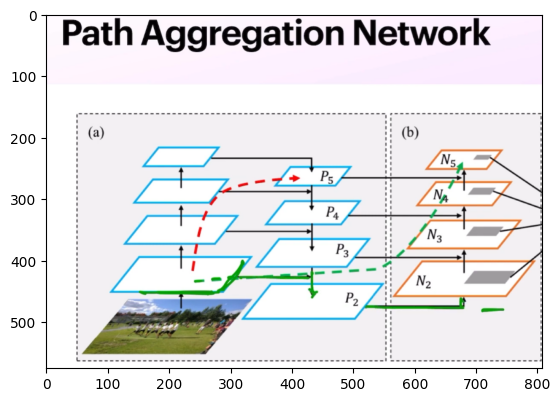

In [13]:
plt.imshow(cv.cvtColor(cv.imread('./../PAN.png'),cv.COLOR_BGR2RGB))

In [14]:
class PANet(nn.Module):
    def __init__(self, features):
        super(PANet, self).__init__()
        # Assuming 'features' is a list of channel sizes for the feature maps at different resolutions
        self.features = features
        self.top_down_layers = nn.ModuleList()
        self.bottom_up_layers = nn.ModuleList()
        
        # Create top-down layers
        for i in range(len(features) - 1, 0, -1):
            self.top_down_layers.append(nn.Sequential(
                nn.Conv2d(features[i], features[i - 1], 1, bias=False),
                nn.BatchNorm2d(features[i - 1]),
                nn.LeakyReLU(0.1),
                nn.Upsample(scale_factor=2)
            ))
        
        # Create bottom-up layers
        for i in range(1, len(features)):
            self.bottom_up_layers.append(nn.Sequential(
                nn.Conv2d(features[i - 1], features[i], 3, padding=1, bias=False),
                nn.BatchNorm2d(features[i]),
                nn.LeakyReLU(0.1),
                nn.MaxPool2d(2)
            ))
    
    def forward(self, inputs):
        x = inputs[-1]
        top_down_features = []
        # Top-down pathway
        for feature, layer in zip(reversed(inputs[:-1]), self.top_down_layers):
            x = layer(x)
            top_down_features.append(x + feature)
        
        # Bottom-up pathway
        x = top_down_features[-1]
        for feature, layer in zip(top_down_features[:-1][::-1], self.bottom_up_layers):
            x = layer(x + feature)
        
        return x

# Creating YOLO MODEL FROM SCRATCH USING 1,2 and 3

In [16]:
class YOLOv5(nn.Module):
    def __init__(self):
        super(YOLOv5, self).__init__()
        # Define CSPNet Backbone
        self.backbone = CSPBlock() # This needs to be defined based on your CSPNet configuration
        
        # Define SPP layer assuming the output of CSPNet is 512 channels
        self.spp = SPP(in_channels=512, out_channels=512)
        
        # Define PANet assuming specific channel sizes for the feature maps
        self.panet = PANet(features=[128, 256, 512, 1024]) # Example channel sizes
        
    def forward(self, x):
        # Extract features using the backbone
        features = self.backbone(x)
        
        # Apply SPP on the last feature map
        spp_features = self.spp(features[-1])
        features[-1] = spp_features
        
        # Integrate features using PANet
        output = self.panet(features)
        return output
